# Introduction

# Data preprocessing

In [1]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)
library(ggpubr)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.3     v tibble    3.2.1
v purrr     1.0.2     v tidyr     1.3.1
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attachement du package : 'gridExtra'


L'objet suivant est masqué depuis 'package:dplyr':

    combine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attachement du package : 'plotly'


L'objet suivant est masqué depuis 'package:ggplot2':

    last_plot


L'objet suivant est masqué depuis 'package:stats':

    filter


L'objet suivant est masqué depuis 'package:graphics':

    layout


corrplot 0.92 loaded


Attachement du package : 'reshape2'


L'objet sui

In [2]:
# Lecture des données
path <- "data/"
song <- read.csv(paste0(path, "spotify_songs.csv"), header = TRUE, sep = ",")

# Premières lignes du jeu de données
head(song)

# Vérification du contenu
summary(song)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxury Remix,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury Remix],2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.00e+00,0.0653,0.518,122.036,194754
2,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,4.21e-03,0.3570,0.693,99.972,162600
3,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,2.33e-05,0.1100,0.613,124.008,176616
4,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,9.43e-06,0.2040,0.277,121.956,169093
5,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.00e+00,0.0833,0.725,123.976,189052
6,7fvUMiyapMsRRxr07cU8Ef,Beautiful People (feat. Khalid) - Jack Wins Remix,Ed Sheeran,67,2yiy9cd2QktrNvWC2EUi0k,Beautiful People (feat. Khalid) [Jack Wins Remix],2019-07-11,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,8,-5.385,1,0.1270,0.0799,0.00e+00,0.1430,0.585,124.982,163049


   track_id          track_name        track_artist       track_popularity
 Length:32833       Length:32833       Length:32833       Min.   :  0.00  
 Class :character   Class :character   Class :character   1st Qu.: 24.00  
 Mode  :character   Mode  :character   Mode  :character   Median : 45.00  
                                                          Mean   : 42.48  
                                                          3rd Qu.: 62.00  
                                                          Max.   :100.00  
 track_album_id     track_album_name   track_album_release_date
 Length:32833       Length:32833       Length:32833            
 Class :character   Class :character   Class :character        
 Mode  :character   Mode  :character   Mode  :character        
                                                               
                                                               
                                                               
 playlist_name      playlis

In [3]:
# Check the data types
str(song)

'data.frame':	32833 obs. of  23 variables:
 $ track_id                : chr  "6f807x0ima9a1j3VPbc7VN" "0r7CVbZTWZgbTCYdfa2P31" "1z1Hg7Vb0AhHDiEmnDE79l" "75FpbthrwQmzHlBJLuGdC7" ...
 $ track_name              : chr  "I Don't Care (with Justin Bieber) - Loud Luxury Remix" "Memories - Dillon Francis Remix" "All the Time - Don Diablo Remix" "Call You Mine - Keanu Silva Remix" ...
 $ track_artist            : chr  "Ed Sheeran" "Maroon 5" "Zara Larsson" "The Chainsmokers" ...
 $ track_popularity        : int  66 67 70 60 69 67 62 69 68 67 ...
 $ track_album_id          : chr  "2oCs0DGTsRO98Gh5ZSl2Cx" "63rPSO264uRjW1X5E6cWv6" "1HoSmj2eLcsrR0vE9gThr4" "1nqYsOef1yKKuGOVchbsk6" ...
 $ track_album_name        : chr  "I Don't Care (with Justin Bieber) [Loud Luxury Remix]" "Memories (Dillon Francis Remix)" "All the Time (Don Diablo Remix)" "Call You Mine - The Remixes" ...
 $ track_album_release_date: chr  "2019-06-14" "2019-12-13" "2019-07-05" "2019-07-19" ...
 $ playlist_name           : chr  "Po

In [4]:
# Drop the track_id, track_album_id, playlist_id columns
song <- song[, -c(1, 5, 9)]

# As factor the categorical variables track_artist, playlist_genre, playlist_subgenre, key, mode, playlist_name, track_album_name
song$playlist_name <- as.factor(song$playlist_name)
song$track_album_name <- as.factor(song$track_album_name)
song$track_artist <- as.factor(song$track_artist)
song$playlist_genre <- as.factor(song$playlist_genre)
song$playlist_subgenre <- as.factor(song$playlist_subgenre)
song$key <- factor(song$key, levels = c(-1, 0:11), labels = c("No key detected", "C", "C♯/D♭", "D", "D♯/E♭", "E", "F", "F♯/G♭", "G", "G♯/A♭", "A", "A♯/B♭", "B"))
song$mode <- factor(song$mode, levels = c(0, 1), labels = c("minor", "major"))

# track_album_release_date to date (if the full date is not available, we will use the first day of the year)
song$track_album_release_date <- as.Date(ifelse(nchar(song$track_album_release_date) != 10, 
                                                paste0(substr(song$track_album_release_date, 1, 4), "-01-01"), 
                                                song$track_album_release_date), 
                                         format = "%Y-%m-%d")

# Convert the duration_ms to seconds and rename the column to duration_s
song$duration_s <- song$duration_ms / 1000
song$duration_ms <- NULL

# Check the modified dataset
summary(song)
head(song)

Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

  track_name                  track_artist   track_popularity
 Length:32833       Martin Garrix   :  161   Min.   :  0.00  
 Class :character   Queen           :  136   1st Qu.: 24.00  
 Mode  :character   The Chainsmokers:  123   Median : 45.00  
                    David Guetta    :  110   Mean   : 42.48  
                    Don Omar        :  102   3rd Qu.: 62.00  
                    (Other)         :32196   Max.   :100.00  
                    NA's            :    5                   
                    track_album_name track_album_release_date
 Greatest Hits              :  139   Min.   :1957-01-01      
 Ultimate Freestyle Mega Mix:   42   1st Qu.:2008-08-25      
 Gold                       :   35   Median :2016-08-26      
 Malibu                     :   30   Mean   :2011-08-07      
 Rock & Rios (Remastered)   :   29   3rd Qu.:2019-04-19      
 (Other)                    :32553   Max.   :2020-01-29      
 NA's                       :    5                           
        

,track_name,track_artist,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s
,<chr>,<fct>,<int>,<fct>,<date>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,I Don't Care (with Justin Bieber) - Loud Luxury Remix,Ed Sheeran,66,I Don't Care (with Justin Bieber) [Loud Luxury Remix],2019-06-14,Pop Remix,pop,dance pop,0.748,0.916,F<U+266F>/G<U+266D>,-2.634,major,0.0583,0.1020,0.00e+00,0.0653,0.518,122.036,194.754
2,Memories - Dillon Francis Remix,Maroon 5,67,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,pop,dance pop,0.726,0.815,B,-4.969,major,0.0373,0.0724,4.21e-03,0.3570,0.693,99.972,162.600
3,All the Time - Don Diablo Remix,Zara Larsson,70,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,pop,dance pop,0.675,0.931,C<U+266F>/D<U+266D>,-3.432,minor,0.0742,0.0794,2.33e-05,0.1100,0.613,124.008,176.616
4,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,Call You Mine - The Remixes,2019-07-19,Pop Remix,pop,dance pop,0.718,0.930,G,-3.778,major,0.1020,0.0287,9.43e-06,0.2040,0.277,121.956,169.093
5,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,pop,dance pop,0.650,0.833,C<U+266F>/D<U+266D>,-4.672,major,0.0359,0.0803,0.00e+00,0.0833,0.725,123.976,189.052
6,Beautiful People (feat. Khalid) - Jack Wins Remix,Ed Sheeran,67,Beautiful People (feat. Khalid) [Jack Wins Remix],2019-07-11,Pop Remix,pop,dance pop,0.675,0.919,G<U+266F>/A<U+266D>,-5.385,major,0.1270,0.0799,0.00e+00,0.1430,0.585,124.982,163.049


In [5]:
# Check for missing values
colSums(is.na(song))

# Drop the missing values
song <- na.omit(song)

# Check the modified dataset
colSums(is.na(song))

str(song)

track_name             track_artist         track_popularity 
                       5                        5                        0 
        track_album_name track_album_release_date            playlist_name 
                       5                        0                        0 
          playlist_genre        playlist_subgenre             danceability 
                       0                        0                        0 
                  energy                      key                 loudness 
                       0                        0                        0 
                    mode              speechiness             acousticness 
                       0                        0                        0 
        instrumentalness                 liveness                  valence 
                       0                        0                        0 
                   tempo               duration_s 
                       0                        0

track_name             track_artist         track_popularity 
                       0                        0                        0 
        track_album_name track_album_release_date            playlist_name 
                       0                        0                        0 
          playlist_genre        playlist_subgenre             danceability 
                       0                        0                        0 
                  energy                      key                 loudness 
                       0                        0                        0 
                    mode              speechiness             acousticness 
                       0                        0                        0 
        instrumentalness                 liveness                  valence 
                       0                        0                        0 
                   tempo               duration_s 
                       0                        0

'data.frame':	32828 obs. of  20 variables:
 $ track_name              : chr  "I Don't Care (with Justin Bieber) - Loud Luxury Remix" "Memories - Dillon Francis Remix" "All the Time - Don Diablo Remix" "Call You Mine - Keanu Silva Remix" ...
 $ track_artist            : Factor w/ 10692 levels "'Til Tuesday",..: 2848 6185 10633 9373 5530 2848 5000 8320 761 8562 ...
 $ track_popularity        : int  66 67 70 60 69 67 62 69 68 67 ...
 $ track_album_name        : Factor w/ 19743 levels "'74 - '75 (feat. Susan Tyler)",..: 7928 10684 981 2869 15185 1882 11515 13093 17788 8155 ...
 $ track_album_release_date: Date, format: "2019-06-14" "2019-12-13" ...
 $ playlist_name           : Factor w/ 449 levels "\"Permanent Wave\"",..: 309 309 309 309 309 309 309 309 309 309 ...
 $ playlist_genre          : Factor w/ 6 levels "edm","latin",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ playlist_subgenre       : Factor w/ 24 levels "album rock","big room",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ danceability            : num  0.7

# Réduction de dimension

Dans cette partie, nous allons effectuer une analyse en composantes principales (ACP) sur les données prétraitées. L'ACP est une technique de réduction de dimension qui permet de projeter les données d'origine dans un espace de dimension inférieure. Nous avons gardé 20 variables et nous allons étudier s'il est possible de réduire la dimensionnalité de ces données tout en préservant un maximum d'information.

## Analyse en Composantes Principales (ACP)

Ici on ne sélectionne que les variables quantitatives, en y ajoutant une variable qualitative (playlist_genre) pour voir si elle a un impact sur la projection des données. On garde au final 11 variables quantitatives et 1 variable qualitative.

On décide de normaliser les données avant de faire l'ACP car l'ACP est sensible à l'échelle des variables. On va donc centrer et réduire les données.

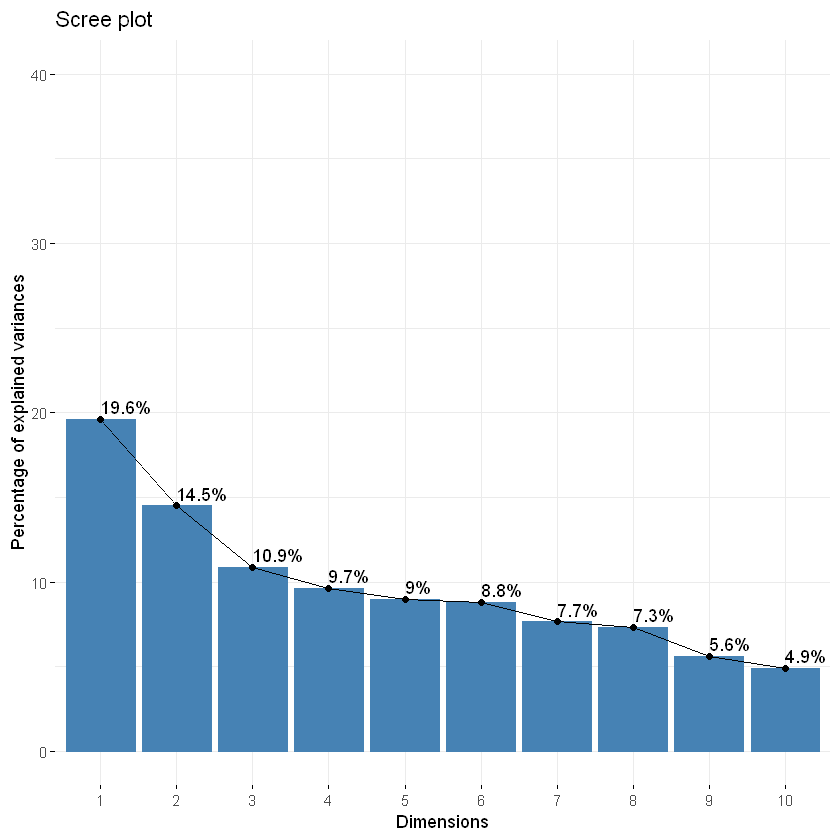

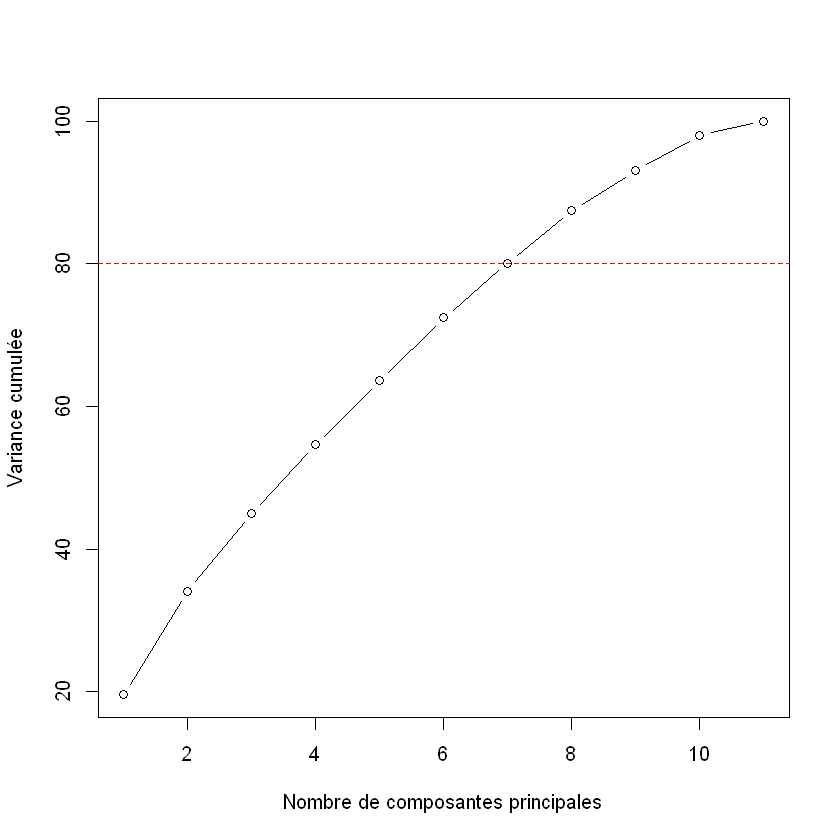

In [6]:
# PCA analysis using FactoMineR
song_pca <- song[, c(3, 7, 9:10, 12, 14:20)]

# Perform PCA
pca <- PCA(song_pca,scale.unit = TRUE, graph = FALSE,ncp = 7,quali.sup = 2)

# Afficher le pourcentage de variance expliquée par chaque composante principale
fviz_eig(pca, addlabels = TRUE, ylim = c(0, 40))

# Calculer la variance cumulée
explained_variance <- pca$eig[, 2]  # La deuxième colonne contient le pourcentage de variance expliquée
cumulative_variance <- cumsum(explained_variance) 

# Tracer la variance cumulée
plot(cumulative_variance, xlab = "Nombre de composantes principales", ylab = "Variance cumulée", type = "b")
abline(h = 80, col = "red", lty = 2)  # Ligne horizontale à 80% de variance expliquée

**Interprétation :** 

L’analyse de la variance expliquée montre que les 7 premières composantes principales permettent de représenter 80,1 % de la variance totale du jeu de données. Cela signifie que l’essentiel de l’information contenue dans les 11 variables numériques initiales (comme danceability, energy, speechiness, tempo, etc.) peut être résumé avec seulement 7 dimensions, ce qui représente une réduction significative de la complexité du dataset tout en conservant une bonne qualité descriptive.

Dans cette optique de réduction de dimension, il serait pertinent de conserver ces 7 composantes principales pour la suite des analyses (clustering, visualisation, classification), car elles capturent la structure principale des données tout en éliminant le "bruit".

Dans l’analyse factorielle, nous avons choisi d’interpréter les trois premières composantes principales, qui à elles seules expliquent 45 % de la variance totale. Elles offrent un bon compromis entre lisibilité et pertinence pour une visualisation ou une première analyse des relations entre les variables et les genres musicaux (playlist_genre).

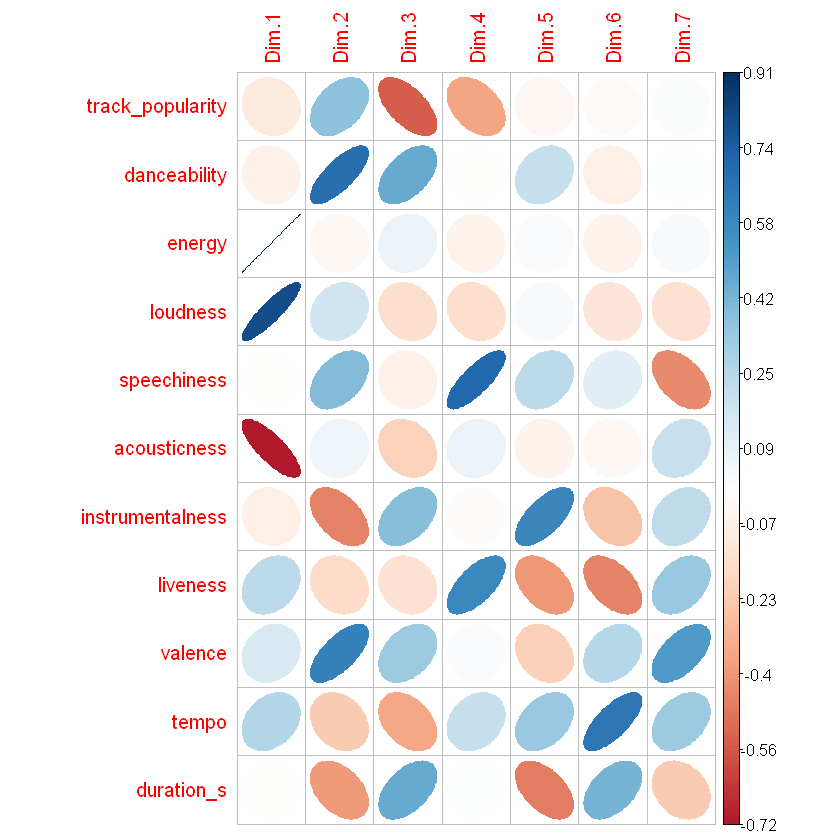

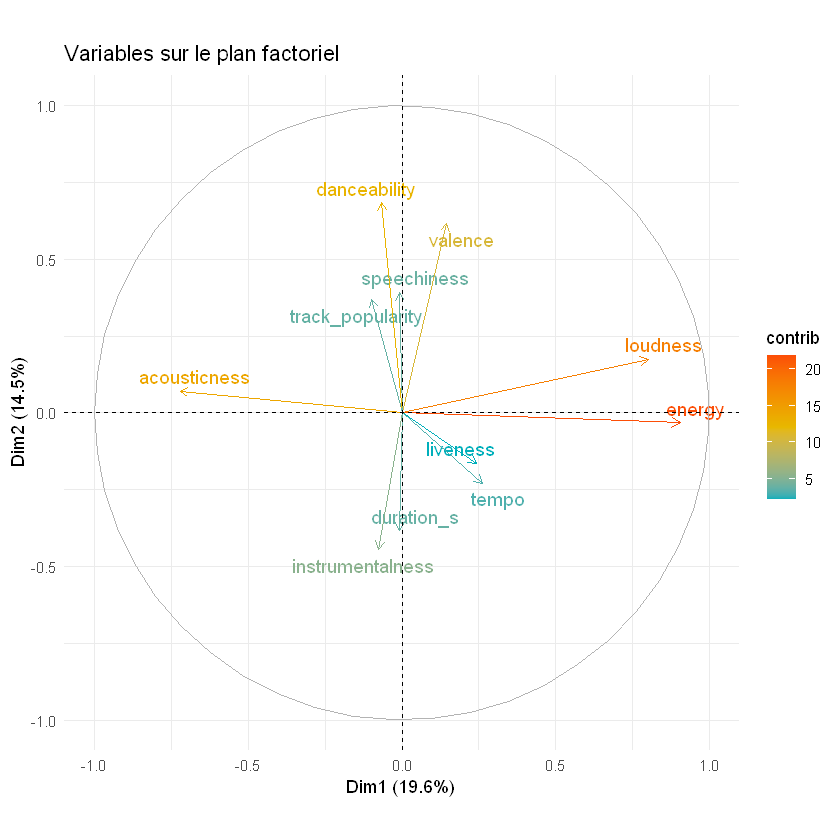

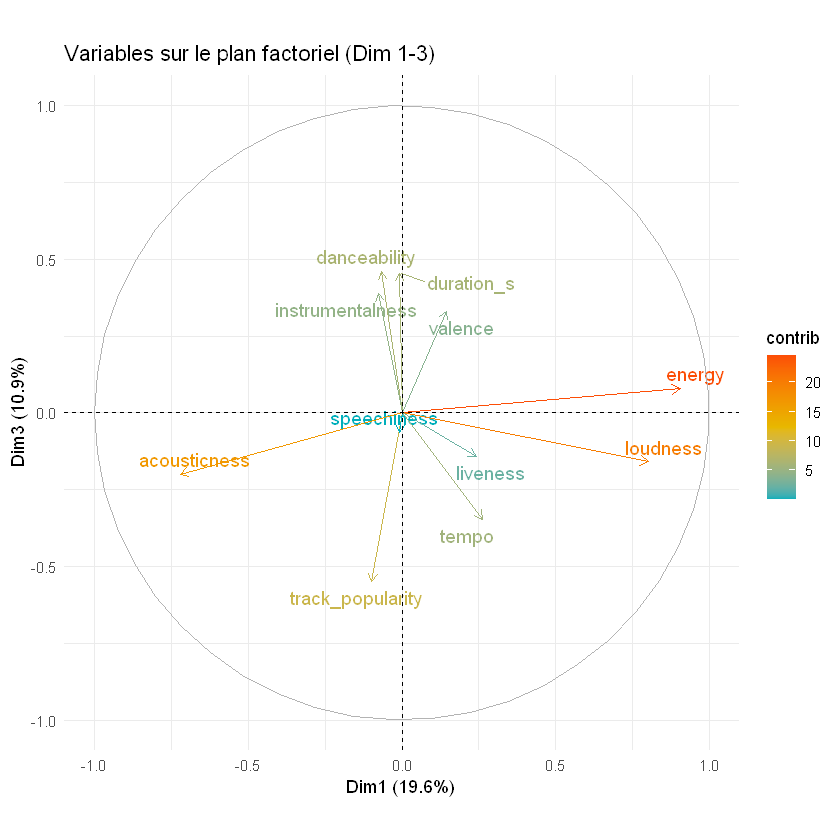

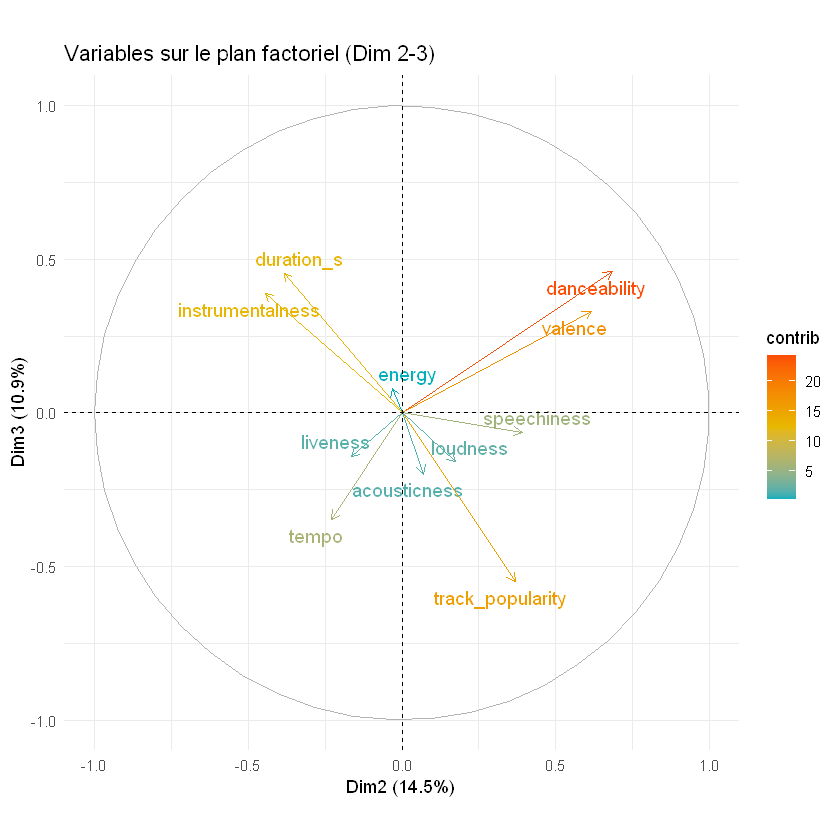

In [7]:
# Corrélation des variables
corrplot(pca$var$cor, is.corr = FALSE, method = "ellipse")

# Tracer les variables sur le plan factoriel dim 1-2
fviz_pca_var(pca, axes=c(1,2),col.var = "contrib", gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), repel = TRUE) +
  labs(title = "Variables sur le plan factoriel") +
  theme_minimal()

# Tracer les variables sur le plan factoriel dim 1-3
  fviz_pca_var(pca, axes = c(1, 3), col.var = "contrib", 
         gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
         repel = TRUE) +
    labs(title = "Variables sur le plan factoriel (Dim 1-3)") +
    theme_minimal()

# Tracer les variables sur le plan factoriel dim 2-3
  fviz_pca_var(pca, axes = c(2, 3), col.var = "contrib", 
         gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
         repel = TRUE) +
    labs(title = "Variables sur le plan factoriel (Dim 2-3)") +
    theme_minimal()

La table des correlations et les trois graphiques ci-dessus représentent les projections des features sur les trois premières composantes principales nous donne des informations sur la structure des données réduites.

**Composante principale 1 :**
    
Les variables energy (-0.91), loudness (-0.80) et acousticness (+0.72) sont linéairement corrélées avec la première composante principale, en soulignant que energy et loudness sont inversément corrélées avec acousticness. Cela indique que la CP1 oppose les morceaux énergiques, forts en volume et peu acoustiques (ex : rock, électro) aux morceaux calmes, acoustiques et peu énergétiques (ex : folk, classique).

**Composante principale 2 :**

Sur le graphique de gauche, on remarque une opposition des variables instrumentalness (+0.45), duration_s (+0.38) contre danceability (-0.68), valence (-0.62), track_popularity (-0.37), speechiness (-0.39).

Cette composante principale oppose deux profils de morceaux :
    D’un côté, les morceaux instrumentaux, longs et peu populaires (forte contribution de instrumentalness et duration_s), souvent associés à des genres comme le classique ou le jazz.
    De l’autre, les chansons courtes, dansantes, joyeuses et populaires (forte contribution de danceability, valence et track_popularity), typiques de la pop ou de la musique de club.
    Enfin, cette opposition suggère que les morceaux avec des paroles marquées (speechiness) et une structure rythmique engageante (danceability) sont plus susceptibles de générer de la popularité.

**Composantes principales 2 et 3 :**

Sur le graphique au centre, on peut extraire plusieurs informations :
    Les morceaux dansants et joyeux (haute valence) s'opposent dans une moindre mesure aux morceaux de faible tempo. De plus, ces morceaux semblent avoir peu de versions live.
    On observe aussi que les morceaux instrumentaux et longs ont généralement une faible popularité, tandis que les morceaux courts et peu instrumentaux sont souvent plus populaires, ce qui est typique de la musique pop, qui est souvent plus accessible et commerciale.

**Composante principale 3 :**

La troisième composante (CP3) révèle un paradoxe : elle regroupe des morceaux à fort potentiel dansant (danceability) et mood positif (valence), mais qui restent peu populaires (track_popularity). Ces morceaux sont souvent instrumentaux (instrumentalness), longs (duration_s) et à tempo faible (tempo), ce qui les éloigne des standards des charts. Cette composante pourrait représenter des créations artistiques équilibrant danse et complexité, mais peinant à atteindre un large public.


La troisième composante principale met en lumière une tension plus subtile entre deux types de morceaux aux caractéristiques inattendues.

Du côté des contributions négatives, on retrouve des titres de pop et R&B calmes et acoustiques comme raindrops (an angel cried) (Ariana Grande) ou You Are The Reason (Calum Scott). Ces chansons ont :

    une acousticness élevée (acapela, guitare acoustique, piano),
    un tempo légèrement plus rapide que la médiane des morceaux,
    une faible énergie, mais un potentiel émotionnel fort (valence variable).

Comme suggéré par la PC3, ces morceaux rencontrent un certain succès, illustrant un profil de chansons émotionnelles, accessibles et bien produites, souvent interprétées par des artistes grand public au style sobre et expressif.

Les contributions positives, quant à elles, sont largement dominées par des morceaux EDM ou latino instrumentaux, comme I Feel Love ou Chase. Ces morceaux sont :

    longs,
    très instrumentaux,
    énergiques mais souvent moins "accessibles" émotionnellement (valence très élevée mais peu de paroles, structure répétitive).

Ils présentent également une popularité extrêmement faible, allant de 0 à 8. Ces productions s’adressent probablement à un public averti ou sont conçues pour des usages spécifiques (DJ sets, ambiances electro), ce qui les éloigne des standards de la musique grand public.

Ces observations confirment que la PC3 oppose des créations acoustiques à forte charge émotionnelle à des morceaux instrumentaux, électroniques, longs, aux dynamiques parfois complexes ou répétitives.

On remarque le signe des contributions est inversé par rapport à l'analyse en composantes principales (ACP) réalisée sous Python.

**Remarque:** on peut noter que les valeurs ne sont pas exactement les mêmes que sur le notebook Python. L'ACP sous R ne prend pas forcément la même base que sur Python, ce qui explique les valeurs parfois négatives ou positives.

Pour mieux comprendre à quoi correspond les type morceaux extraits par ces composantes principales, nous allons regarder les morceaux (individus) contribuant le plus à chacune des composantes principales.

In [8]:
# Extraction des coordonnées des individus sur la dimension 1
dim1_coords <- pca$ind$coord[, 1]

# Récupération des indices des 5 valeurs minimales et maximales
min_indices <- order(dim1_coords)[1:5]
max_indices <- order(dim1_coords, decreasing = TRUE)[1:5]

# Sélection complète des individus extrêmes avec toutes leurs caractéristiques
extreme_individuals <- song[c(min_indices, max_indices), ]

# Ajout d'une colonne pour identifier la catégorie (minimum ou maximum)
extreme_individuals$Category <- c(rep("Minimum", 5), rep("Maximum", 5))
extreme_individuals$Dim1_Value <- dim1_coords[c(min_indices, max_indices)]

# Réorganiser les colonnes pour mettre Category et Dim1_Value au début
col_order <- c("Category", "Dim1_Value", colnames(extreme_individuals)[1:(ncol(extreme_individuals)-2)])
extreme_individuals <- extreme_individuals[, col_order]

# Pour une meilleure visualisation en format tableau
if (requireNamespace("knitr", quietly = TRUE)) {
  knitr::kable(extreme_individuals)
}



|      |Category | Dim1_Value|track_name                      |track_artist         | track_popularity|track_album_name                                                                            |track_album_release_date |playlist_name                                     |playlist_genre |playlist_subgenre | danceability|   energy|key                 | loudness|mode  | speechiness| acousticness| instrumentalness| liveness| valence|   tempo| duration_s|
|:-----|:--------|----------:|:-------------------------------|:--------------------|----------------:|:-------------------------------------------------------------------------------------------|:------------------------|:-------------------------------------------------|:--------------|:-----------------|------------:|--------:|:-------------------|--------:|:-----|-----------:|------------:|----------------:|--------:|-------:|-------:|----------:|
|17011 |Minimum  | -10.027983|Peaceful Forest                 |The Sleep Specialist | 



Pour mieux cerner les types de morceaux représentés aux extrémités de la première composante principale (PC1), nous avons identifié les individus (chansons) ayant les contributions les plus élevées, positives comme négatives.

    Du côté des contributions positives, on retrouve majoritairement des morceaux rock, hard rock ou pop rock très énergiques et puissants tels que American Idiot (Green Day), Beauty Queen (BLVK SWVN) ou ATTENTION ATTENTION (Shinedown). Ces morceaux sont caractérisés par une énergie élevée, une forte intensité sonore (loudness) et une faible acoustique, ce qui confirme bien la structure mise en évidence par la CP1. Notons aussi This Is How We Do It (Montell Jordan), un morceau R&B énergique, qui se distingue des autres par son genre mais partage les mêmes caractéristiques acoustiques.

    À l’opposé, les morceaux à contribution très négative sur PC1 sont des titres à forte acoustique, peu énergiques et très faibles en loudness. Il s'agit notamment de sons ambiants, relaxants ou naturels, comme Peaceful Forest ou Tropical Rainforest at Dawn, mais aussi de titres R&B ou indie très doux (Small de chloe moriondo). Ces morceaux incarnent l'autre extrémité de la CP1 : des chansons calmes, acoustiques et à faible énergie, souvent issues de sous-genres comme tropical, indie poptimism ou new jack swing.

Cette opposition renforce l’interprétation de la CP1 comme un axe énergie / intensité sonore vs. calme / acoustique, pertinent pour distinguer deux grandes familles de styles musicaux dans le dataset.


In [9]:
# Extraction des coordonnées des individus sur la dimension 2
dim2_coords <- pca$ind$coord[, 2]

# Récupération des indices des 5 valeurs minimales et maximales
min_indices_dim2 <- order(dim2_coords)[1:5]
max_indices_dim2 <- order(dim2_coords, decreasing = TRUE)[1:5]

# Sélection complète des individus extrêmes avec toutes leurs caractéristiques
extreme_individuals_dim2 <- song[c(min_indices_dim2, max_indices_dim2), ]

# Ajout d'une colonne pour identifier la catégorie (minimum ou maximum)
extreme_individuals_dim2$Category <- c(rep("Minimum", 5), rep("Maximum", 5))
extreme_individuals_dim2$Dim2_Value <- dim2_coords[c(min_indices_dim2, max_indices_dim2)]

# Réorganiser les colonnes pour mettre Category et Dim2_Value au début
col_order <- c("Category", "Dim2_Value", colnames(extreme_individuals_dim2)[1:(ncol(extreme_individuals_dim2)-2)])
extreme_individuals_dim2 <- extreme_individuals_dim2[, col_order]

# Pour une meilleure visualisation en format tableau
if (requireNamespace("knitr", quietly = TRUE)) {
  knitr::kable(extreme_individuals_dim2)
}



|      |Category | Dim2_Value|track_name                           |track_artist               | track_popularity|track_album_name                                            |track_album_release_date |playlist_name                                      |playlist_genre |playlist_subgenre | danceability|   energy|key                 | loudness|mode  | speechiness| acousticness| instrumentalness| liveness| valence|   tempo| duration_s|
|:-----|:--------|----------:|:------------------------------------|:--------------------------|----------------:|:-----------------------------------------------------------|:------------------------|:--------------------------------------------------|:--------------|:-----------------|------------:|--------:|:-------------------|--------:|:-----|-----------:|------------:|----------------:|--------:|-------:|-------:|----------:|
|17019 |Minimum  |  -6.312385|Relaxing Crickets And Waterfall      |Natural Sound Makers       |               52|Forest By Ni



Côté contributions positives, on retrouve des titres principalement rap et latino, tels que Suge de DaBaby ou LAX de B0nds. Ces morceaux sont :

    courts,
    dansants (haute danceability),
    avec une valence élevée (émotion positive),
    mais également avec un certain niveau de speechiness, notamment pour les titres rap.

Ces morceaux partagent donc des caractéristiques propres aux chansons énergétiques, rythmées et populaires, souvent taillées pour le streaming, avec des formats courts, accrocheurs et directs.

À l’opposé, les morceaux ayant une forte contribution négative à PC2 sont très différents : on retrouve des paysages sonores naturels, ambiants ou instrumentaux comme Rain Forest and Tropical Beach Sound, Caribbean Thunderstorm, ou encore Battlement. Ces titres sont :

    longs,
    instrumentaux (forte instrumentalness),
    avec une faible valence et peu de parole,
    et souvent issus de sous-genres comme tropical, album rock, ou ambient.

Cela confirme l’interprétation initiale de la PC2 comme un axe opposant la musique instrumentale, longue et contemplative à une musique populaire, dansante et rythmée.


In [10]:
# Extraction des coordonnées des individus sur la dimension 3
dim3_coords <- pca$ind$coord[, 3]

# Récupération des indices des 5 valeurs minimales et maximales
min_indices_dim3 <- order(dim3_coords)[1:5]
max_indices_dim3 <- order(dim3_coords, decreasing = TRUE)[1:5]

# Sélection complète des individus extrêmes avec toutes leurs caractéristiques
extreme_individuals_dim3 <- song[c(min_indices_dim3, max_indices_dim3), ]

# Ajout d'une colonne pour identifier la catégorie (minimum ou maximum)
extreme_individuals_dim3$Category <- c(rep("Minimum", 5), rep("Maximum", 5))
extreme_individuals_dim3$Dim3_Value <- dim3_coords[c(min_indices_dim3, max_indices_dim3)]

# Réorganiser les colonnes pour mettre Category et Dim3_Value au début
col_order <- c("Category", "Dim3_Value", colnames(extreme_individuals_dim3)[1:(ncol(extreme_individuals_dim3)-2)])
extreme_individuals_dim3 <- extreme_individuals_dim3[, col_order]

# Pour une meilleure visualisation en format tableau
if (requireNamespace("knitr", quietly = TRUE)) {
  knitr::kable(extreme_individuals_dim3)
}



|      |Category | Dim3_Value|track_name                 |track_artist    | track_popularity|track_album_name                                     |track_album_release_date |playlist_name                                                 |playlist_genre |playlist_subgenre         | danceability| energy|key                 | loudness|mode  | speechiness| acousticness| instrumentalness| liveness| valence|   tempo| duration_s|
|:-----|:--------|----------:|:--------------------------|:---------------|----------------:|:----------------------------------------------------|:------------------------|:-------------------------------------------------------------|:--------------|:-------------------------|------------:|------:|:-------------------|--------:|:-----|-----------:|------------:|----------------:|--------:|-------:|-------:|----------:|
|2254  |Minimum  |  -3.686347|raindrops (an angel cried) |Ariana Grande   |               35|Sweetener                                            |2

La troisième composante principale met en lumière une tension plus subtile entre deux types de morceaux aux caractéristiques inattendues.

Du côté des contributions négatives, on retrouve des titres de pop et R&B calmes et acoustiques comme raindrops (an angel cried) (Ariana Grande) ou You Are The Reason (Calum Scott). Ces chansons ont :

    une acousticness élevée (acapela, guitare acoustique, piano),
    un tempo légèrement plus rapide que la médiane des morceaux,
    une faible énergie, mais un potentiel émotionnel fort (valence variable).

Comme suggéré par la PC3, ces morceaux rencontrent un certain succès, illustrant un profil de chansons émotionnelles, accessibles et bien produites, souvent interprétées par des artistes grand public au style sobre et expressif.

Les contributions positives, quant à elles, sont largement dominées par des morceaux EDM ou latino instrumentaux, comme I Feel Love ou Chase. Ces morceaux sont :

    longs,
    très instrumentaux,
    énergiques mais souvent moins "accessibles" émotionnellement (valence très élevée mais peu de paroles, structure répétitive).

Ils présentent également une popularité extrêmement faible, allant de 0 à 8. Ces productions s’adressent probablement à un public averti ou sont conçues pour des usages spécifiques (DJ sets, ambiances electro), ce qui les éloigne des standards de la musique grand public.

Ces observations confirment que la PC3 oppose des créations acoustiques à forte charge émotionnelle à des morceaux instrumentaux, électroniques, longs, aux dynamiques parfois complexes ou répétitives.

On remarque le signe des contributions est inversé par rapport à l'analyse en composantes principales (ACP) réalisée sous Python.

## MDS


Goodness-of-fit (GOF):
[1] 0.3413562 0.3413562


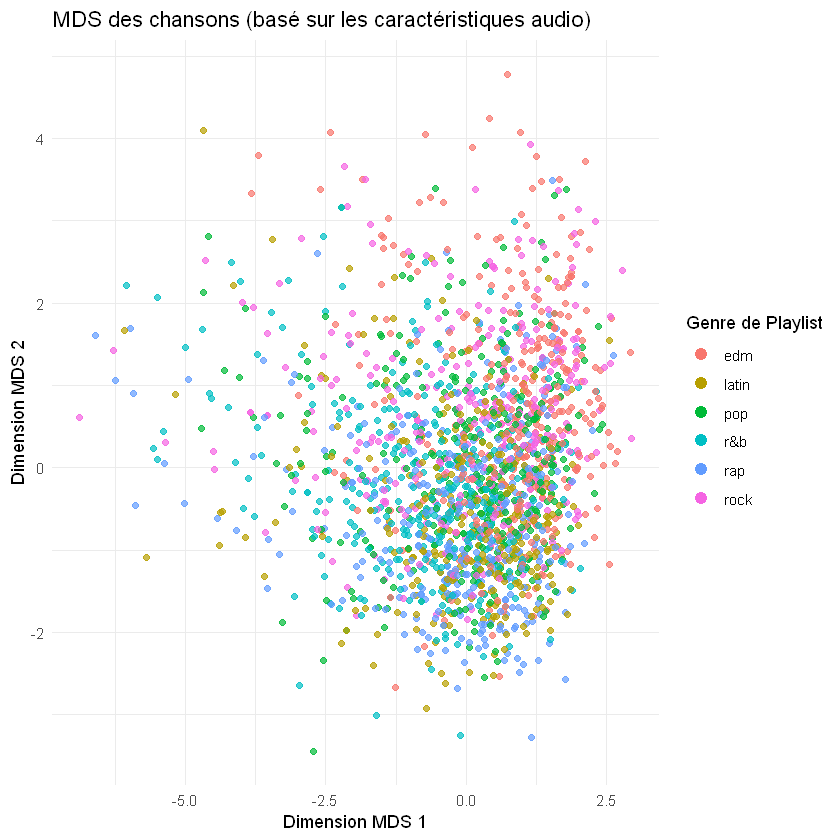

In [12]:
# 1. Sélectionner les variables numériques pertinentes (similaire à l'ACP)
numerical_features <- song[, c("danceability", "energy", "loudness", "speechiness", 
                               "acousticness", "instrumentalness", "liveness", 
                               "valence", "tempo", "track_popularity", "duration_s")]

# S'assurer qu'il n'y a pas de NA
numerical_features <- na.omit(numerical_features)

# Limiter à 2000 chansons pour éviter crash mémoire
set.seed(42)
if (nrow(numerical_features) > 2000) {
  sample_idx <- sample(seq_len(nrow(numerical_features)), 2000)
  numerical_features <- numerical_features[sample_idx, ]
}

# Standardiser
scaled_numerical_features <- scale(numerical_features)
dist_matrix <- dist(scaled_numerical_features)

# MDS sans add=TRUE
mds_result <- cmdscale(dist_matrix, k = 2, eig = TRUE)

mds_points <- as.data.frame(mds_result$points)
colnames(mds_points) <- c("Dim1", "Dim2")

# Récupérer le genre correspondant
if (exists("sample_idx")) {
  temp_df_for_mds <- song[, c("playlist_genre", "danceability", "energy", "loudness", "speechiness", 
                              "acousticness", "instrumentalness", "liveness", 
                              "valence", "tempo", "track_popularity", "duration_s")]
  temp_df_for_mds_clean <- na.omit(temp_df_for_mds)
  temp_df_for_mds_clean <- temp_df_for_mds_clean[sample_idx, ]
} else {
  temp_df_for_mds <- song[, c("playlist_genre", "danceability", "energy", "loudness", "speechiness", 
                              "acousticness", "instrumentalness", "liveness", 
                              "valence", "tempo", "track_popularity", "duration_s")]
  temp_df_for_mds_clean <- na.omit(temp_df_for_mds)
}

mds_points$playlist_genre <- temp_df_for_mds_clean$playlist_genre

# Visualisation
ggplot(mds_points, aes(x = Dim1, y = Dim2, color = playlist_genre)) +
  geom_point(alpha = 0.7) +
  labs(title = "MDS des chansons (basé sur les caractéristiques audio)",
       x = "Dimension MDS 1",
       y = "Dimension MDS 2",
       color = "Genre de Playlist") +
  theme_minimal() +
  guides(color = guide_legend(override.aes = list(alpha = 1, size = 3)))

# Goodness-of-fit
cat("\nGoodness-of-fit (GOF):\n")
print(mds_result$GOF)


## t-SNE


  Une version binaire est disponible mais la version du source est plus
  récente:
      binary source needs_compilation
Rtsne   0.16   0.17              TRUE

  Binaries will be installed
package 'Rtsne' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\matte\AppData\Local\Temp\Rtmp08RRCs\downloaded_packages
Performing PCA
Read the 1962 x 11 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.37 seconds (sparsity = 0.067245)!
Learning embedding...
Iteration 50: error is 77.561850 (50 iterations in 0.40 seconds)
Iteration 100: error is 77.546243 (50 iterations in 0.49 seconds)
Iteration 150: error is 77.202230 (50 iterations in 0.40 seconds)
Iteration 200: error is 77.198202 (50 iterations in 0.27 seconds)
Iteration 250: error is 77.198075 (50 iterations in 0.34 seconds)
Iteration 300: error is 2.299975 (50 iterations 

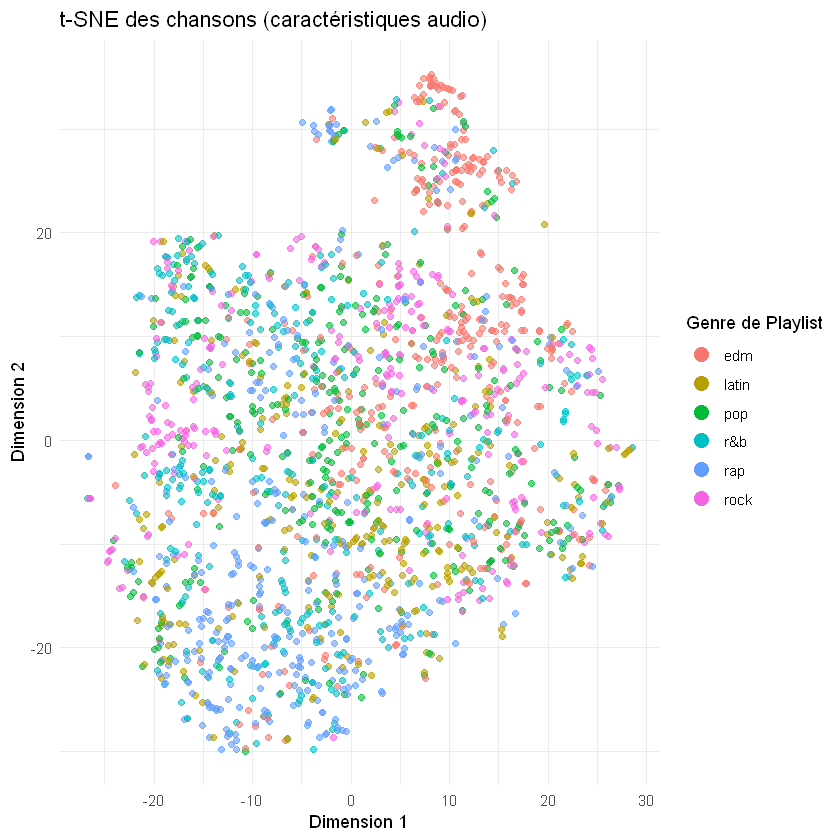

In [14]:
install.packages("Rtsne")
library(Rtsne)
library(ggplot2)

# Supprimer les doublons
scaled_numerical_features_unique <- unique(scaled_numerical_features)

# Identifier les lignes uniques
unique_rows <- !duplicated(scaled_numerical_features)

# Conserver uniquement les genres correspondant aux lignes uniques
playlist_genre_unique <- temp_df_for_mds_clean$playlist_genre[unique_rows]

# Exécuter t-SNE
set.seed(42)
tsne_result <- Rtsne(scaled_numerical_features_unique, dims = 2, perplexity = 30, verbose = TRUE)

# Préparer le dataframe pour ggplot
tsne_df <- as.data.frame(tsne_result$Y)
colnames(tsne_df) <- c("Dim1", "Dim2")
tsne_df$playlist_genre <- playlist_genre_unique

# Visualisation
ggplot(tsne_df, aes(x = Dim1, y = Dim2, color = playlist_genre)) +
  geom_point(alpha = 0.6) +
  labs(title = "t-SNE des chansons (caractéristiques audio)",
       x = "Dimension 1", y = "Dimension 2",
       color = "Genre de Playlist") +
  theme_minimal() +
  guides(color = guide_legend(override.aes = list(size = 4, alpha = 1)))


## Interprétation des méthodes de MDS et t-SNE

### Interprétation du MDS

Le graphique issu de la MDS montre une concentration importante des points au centre, avec un fort chevauchement entre les différents genres musicaux (`pop`, `rap`, `r&b`, `rock`, etc.). Il n'y a pas de séparation nette ou de regroupement clair visible sur les deux dimensions principales.

Le **Goodness-of-Fit (GOF)** est d’environ **0.34**, ce qui signifie que seulement **34 %** de la structure initiale des distances est préservée dans cette projection bidimensionnelle. Ce score relativement faible traduit une **perte d'information importante**, ce qui rend la visualisation difficile à interpréter de manière fiable.

Cela suggère que :

- Les genres musicaux ne se distinguent pas clairement sur la base des distances euclidiennes entre leurs caractéristiques audio normalisées.
- La MDS, étant une méthode **linéaire**, ne capture pas bien les relations **non linéaires** qui pourraient exister entre les chansons.

---

### Interprétation du t-SNE

Le graphique t-SNE montre une plus grande dispersion des points, avec des zones où certains genres comme `edm` ou `rap` semblent former des **sous-groupes partiellement distincts**. Cependant, on observe encore un chevauchement significatif entre les genres.

Contrairement à la MDS, le t-SNE est une méthode **non linéaire** qui vise à préserver les **voisinages locaux** plutôt que les distances globales. Cela lui permet de mieux mettre en évidence les structures locales, comme des groupes compacts, même si les distances globales ne sont pas interprétables.

L’interprétation du t-SNE suggère que :

- Il existe quelques **régions homogènes** selon certains genres, mais aucune **séparation franche** entre clusters de genres.
- Les caractéristiques audio seules ne suffisent probablement pas à **discriminer clairement** les genres musicaux.
- Le t-SNE offre une visualisation plus riche que la MDS, mais reste difficile à interpréter en l’absence de clusters bien définis.

---

### Conclusion commune

Les deux méthodes révèlent que les genres musicaux dans ce jeu de données **ne sont pas linéairement séparables** sur la base des caractéristiques audio fournies. Le chevauchement visuel suggère soit :

- une **proximité réelle** entre les genres sur le plan acoustique,
- soit un **manque de variabilité** ou de pertinence dans les variables utilisées.

## Analyse en Correspondances Multiples (MCA)

### Objectif
L'Analyse en Correspondances Multiples (MCA) a été réalisée pour explorer les relations entre les variables qualitatives du dataset Spotify. Cette méthode permet de visualiser les associations entre les modalités des variables qualitatives et d'identifier des clusters ou des oppositions significatives.

**1. Variables catégorielles à utiliser dans la MCA**
Voici les variables qualitatives que l'on pourrait envisager d'utiliser pour la MCA sur le dataset Spotify :  
- `track_artist`  
- `track_album_name` (attention à trop de modalités rares, peut-être garder que les plus fréquentes ou ne pas inclure à cause du grand nombre d’artistes)  
- `playlist_name`  
- `playlist_genre`  
- `playlist_subgenre`  
- `key`  
- `mode`  

---

**2. Questions que la MCA peut aider à explorer**

**a) Quels sont les groupes/cluster de modalités similaires ?**
- Est-ce que certains genres et sous-genres de playlists s’associent fréquemment ?  
- Certains "modes" (majeur/minor) sont-ils plus fréquents dans certains genres ?  
- Y a-t-il des clés (`key`) musicales qui sont typiques de certains genres ou playlists ?  

La MCA permettra de représenter graphiquement (biplot) ces modalités et d’identifier des associations fortes.

**b) Est-ce que certains artistes ou playlists ont un profil qualitatif particulier ?**
- Par exemple, certains artistes seraient-ils associés à un genre et sous-genre spécifiques, ou à un mode particulier ?  
- Y a-t-il des clusters d’artistes / playlists qui partagent des caractéristiques particulières (clé, mode, genre) ?

**3. Comment interpréter la MCA ici**

- **Axes factoriels** : Chaque axe correspond à une dimension qui résume des associations fortes entre modalités. Par exemple, un axe peut opposer les genres "Rock" à "Pop", ou des clés majeures à mineures.
- **Modalités proches dans l’espace** : Modalités proches signifient qu’elles co-apparaissent souvent dans les observations (ex. certains genres + mode majeur).
- **Observation** : Si tu represents les observations (chansons) dans l’espace MCA, celles proches partagent des profils catégoriels similaires.

---

**4. Utilisations concrètes/academic use cases**

- **Profil des genres musicaux** : Comprendre quels modes/clés/sous-genres caractérisent les genres populaires sur Spotify.  
- **Segmentation qualitative des playlists** : Y a-t-il des types de playlists/musiques qui partagent des caractéristiques qualitatives communes ?  
- **Analyse de diversité** : Mesurer dans quelle mesure certains artistes/genres sont hétérogènes ou homogènes quant à leurs caractéristiques catégorielles.  
- **Préparation à une classification** : Par exemple, combiner le résultat de la PCA (variables numériques) avec la MCA (variables qualitatives) dans une analyse factorielle mixte ou pour enrichir un modèle prédictif.

---

**5. Exemple de questions précises à poser**

- Les genres musicaux sont-ils liés à certaines tonalités ou modes ?  
- Les sous-genres présents dans la même playlist sont-ils proches ou éloignés dans l’espace MCA ?  
- Y a-t-il des clés rares ou des modes minoritaires associés à certains genres uniquement ?  
- Peut-on détecter des groupes de playlists ou artistes avec des profils qualitatifs similaires ?  

---

**En conclusion**
La MCA t’aide surtout à **explorer et visualiser les relations entre variables qualitatives** et leurs modalités sur ton dataset Spotify, ce qui complète bien la PCA sur les variables numériques. C’est une étape utile pour comprendre la structure qualitative de tes données avant d’envisager une modélisation supervisée ou une analyse plus approfondie.

---

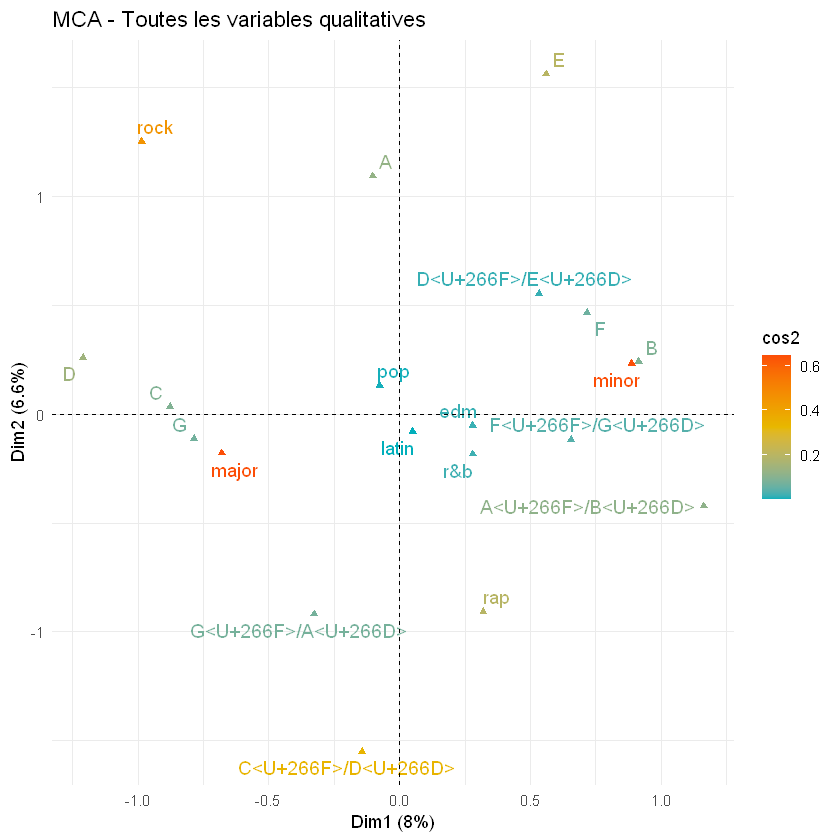

In [15]:
# Sélection de toutes les variables qualitatives pertinentes pour la MCA
qual_vars <- c( 'playlist_genre', 'key', 'mode')
song_mca_all <- song[, qual_vars]

# Réalisation de la MCA avec FactoMineR
mca_all <- MCA(song_mca_all, graph = FALSE)

# Visualisation des modalités sur le plan factoriel
fviz_mca_var(mca_all, col.var = "cos2", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) +
  labs(title = "MCA - Toutes les variables qualitatives") +
  theme_minimal()

### Variables utilisées
Les variables qualitatives sélectionnées pour cette analyse sont :
- `playlist_genre` : Genre de la playlist (ex. rock, pop, rap, etc.).
- `key` : Tonalité musicale (ex. C, D, E♭, etc.).
- `mode` : Mode musical (majeur ou mineur).

### Résultats

#### 1. Axes factoriels
- **Dim1 (8%)** : Cet axe semble opposer des genres musicaux et des tonalités spécifiques :
  - À droite, des genres comme `rap` et des tonalités comme `A♯/B♭` sont associés à des morceaux modernes ou spécifiques.
  - À gauche, des tonalités comme `C` et `G` sont associées à des genres comme `rock`, suggérant une relation avec des styles plus classiques.
- **Dim2 (6.6%)** : Cet axe reflète une distinction entre les modes (`major` et `minor`) et leur association avec certains genres :
  - En haut, le mode `major` est associé à des genres comme `rock`.
  - En bas, le mode `minor` est plus proche de genres comme `rap` et `edm`.

#### 2. Proximité des modalités
- Les modalités proches sur le graphique sont souvent associées dans les données :
  - `pop`, `latin`, `r&b` et `edm` sont centrés par rapport aux modes `minor`et `major`, indiquant qu'ils n'appartiennent pas clairement à un mode spécifique, mais partagent des caractéristiques communes.
  - `rap` est également centré par rapport à ces modes, ce qui suggère que l'utilisation des modes majeurs et mineurs est assez équilibrée dans la composition des morceaux de rap. Toutefois, il reste distinct des groupes `pop`, `latin`, `r&b` et `edm`.
  - `rock` est plus proche de `major`, ce qui suggère que les musiques de ce genre sont souvent associées à des tonalités majeures.
  - Les tonalités comme `B`,`D♯/E♭`,`A♯/B♭`,`F♯/G♭`et `F` sont proches de `minor`, indiquant qu'elles sont souvent utilisées dans des morceaux en mode mineur.
  - Les tonalités comme `C`, `G`,`D` sont proches de `major`, ce qui suggère qu'elles sont souvent utilisées dans des morceaux en mode majeur.

#### 3. Cos2 (Qualité de représentation)
- Les couleurs des points indiquent la qualité de représentation des modalités sur les deux premières dimensions :
  - Les modalités avec des couleurs chaudes (orange/rouge) comme `major` ou `minor` sont bien représentées sur ces axes.
  - Les modalités avec des couleurs froides (bleu/vert) comme certaines tonalités (`C`, `G`) sont moins bien représentées, ce qui signifie qu'elles pourraient être mieux expliquées par d'autres dimensions.

### Conclusion
Cette MCA met en évidence des associations claires entre les genres musicaux, les tonalités (`key`), et les modes (`major`/`minor`). Elle permet de visualiser les relations qualitatives dans les données et d'identifier des clusters ou des oppositions significatives. Par exemple :
- `rock` est distinct des autres genres, avec des tonalités et un mode spécifiques.
- `pop`, `latin`, `r&b` et `edm` partagent des caractéristiques similaires, mais ne sont pas clairement associés à un mode particulier.
- `rap` est centré par rapport aux modes, mais reste distinct des autres genres.

Ces résultats offrent une meilleure compréhension des structures qualitatives des données et peuvent être utilisés pour des analyses complémentaires, comme la segmentation ou la classification.

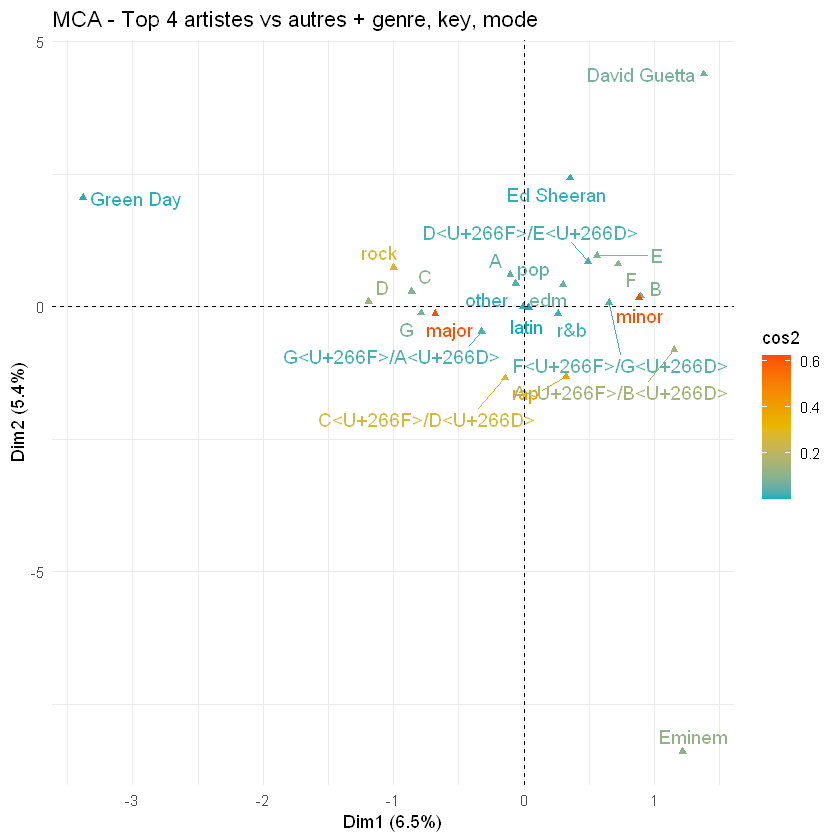

In [16]:
# Identifier les top artists
top_artists <- c("Eminem", "Green Day", "David Guetta", "Ed Sheeran")

# Créer une nouvelle variable track_artist_grouped avec "other" pour les artistes non sélectionnés
song$track_artist_grouped <- as.character(song$track_artist)
song$track_artist_grouped[!(song$track_artist %in% top_artists)] <- "other"
song$track_artist_grouped <- as.factor(song$track_artist_grouped)

# Filtrer le dataset pour ne garder que les morceaux des top artists ou "other"
song_top_other <- song[song$track_artist_grouped %in% c(top_artists, "other"), ]

# Sélection des variables qualitatives pour la MCA
qual_vars_top_other <- c('track_artist_grouped', 'playlist_genre', 'key', 'mode')
song_mca_top_other <- song_top_other[, qual_vars_top_other]

# Réalisation de la MCA
mca_top_other <- MCA(song_mca_top_other, graph = FALSE)

# Visualisation des modalités sur le plan factoriel
fviz_mca_var(mca_top_other, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) +
  labs(title = "MCA - Top 4 artistes vs autres + genre, key, mode") +
  theme_minimal()

### Résultats

#### 1. Proximité des modalités
- Les artistes proches sur le graphique partagent des caractéristiques similaires :
  - `Ed Sheeran` est proche des tonalités `A` et `D`, ainsi que du mode `major`, ce qui reflète son style musical souvent associé à des tonalités classiques.
  - `Green Day` est également associé au mode `major` et à des tonalités comme `C` et `D`, typiques de leur style rock.
  - `David Guetta` est lié à des tonalités comme `F` et `D♯/E♭`, souvent utilisées dans la musique électronique.
  - `Eminem` est associé au mode `minor` et à des tonalités comme `A♯/B♭`, caractéristiques de son style rap.

#### 2. Clusters identifiés
  - `rock` est fortement associé à `Green Day` et au mode `major`.
  - `rap` est lié à `Eminem` et au mode `minor`.
  - `Ed Sheeran` est proche du centre, indiquant un style musical équilibré entre tonalités et modes.

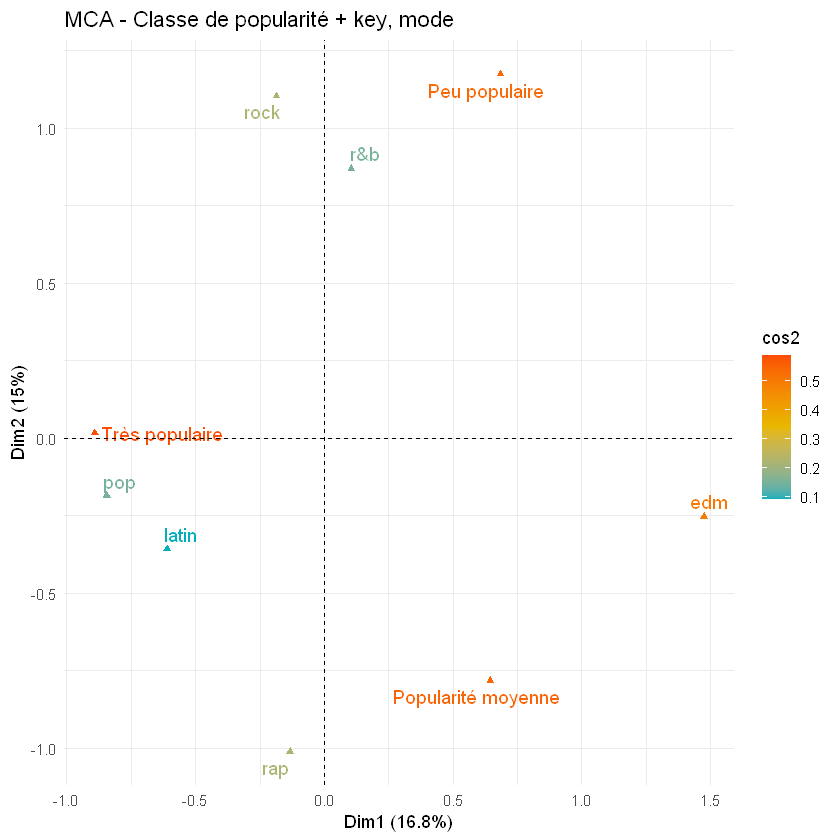

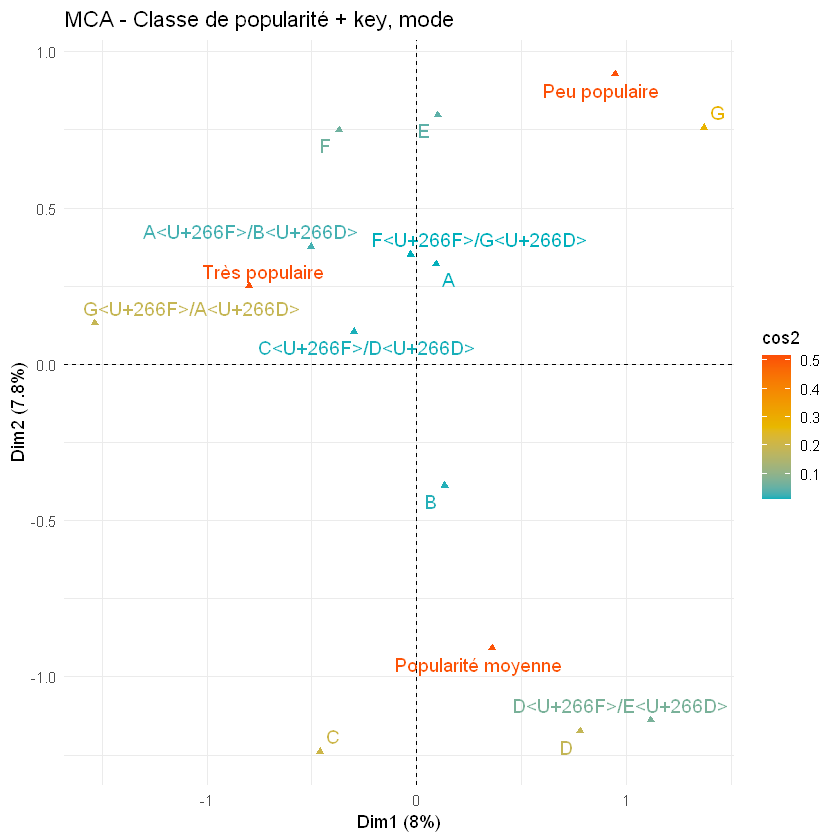

In [17]:
#Création de classe de popularité de track_popularity en facteur Très Populaire, Popularité moyenne, Peu populaire
song$track_popularity_class <- cut(song$track_popularity, 
                                   breaks = c(-1, 20, 50, 100), 
                                   labels = c("Peu populaire", "Popularité moyenne", "Très populaire"),
                                   include.lowest = TRUE)

#MCA avec la classe de popularité et playlist_genre
qual_vars_popularity <- c('track_popularity_class','playlist_genre')
song_mca_popularity <- song[, qual_vars_popularity]
mca_popularity <- MCA(song_mca_popularity, graph = FALSE)

# Visualisation des modalités sur le plan factoriel
fviz_mca_var(mca_popularity, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) +
  labs(title = "MCA - Classe de popularité + key, mode") +
  theme_minimal()

#MCA avec la classe de popularité et key
qual_vars_popularity <- c('track_popularity_class','key')
song_mca_popularity <- song[, qual_vars_popularity]
mca_popularity <- MCA(song_mca_popularity, graph = FALSE)

# Visualisation des modalités sur le plan factoriel
fviz_mca_var(mca_popularity, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE) +
  labs(title = "MCA - Classe de popularité + key, mode") +
  theme_minimal()

## Analyse Factorielle Multiple (MFA)

L’Analyse Factorielle Multiple (MFA) est une méthode d’analyse exploratoire multivariée qui permet d’étudier simultanément plusieurs groupes de variables de nature différente, notamment des variables quantitatives (caractéristiques audio) et qualitatives (genre, tonalité, mode, etc.). 

Dans le contexte de ce projet Spotify, la MFA est particulièrement pertinente car elle va permettre de :
- **Combiner** dans une même analyse les profils audio des morceaux et leurs attributs qualitatifs (genre, mode, key, etc.), en tenant compte de la structure de chaque groupe de variables.
- **Explorer les liens** entre les caractéristiques musicales objectives et les catégories musicales, pour voir par exemple si certains genres ou modes sont associés à des profils audio spécifiques.
- **Visualiser la structure globale** du jeu de données en intégrant toutes les dimensions importantes, ce qui offre une vision plus complète que l’ACP (centrée sur le quantitatif) ou la MCA (centrée sur le qualitatif) seules.

La MFA est donc un outil idéal pour comprendre comment les différentes facettes des chansons (audio et catégorielles) s’articulent et pour identifier des profils ou des clusters mixtes dans le dataset.

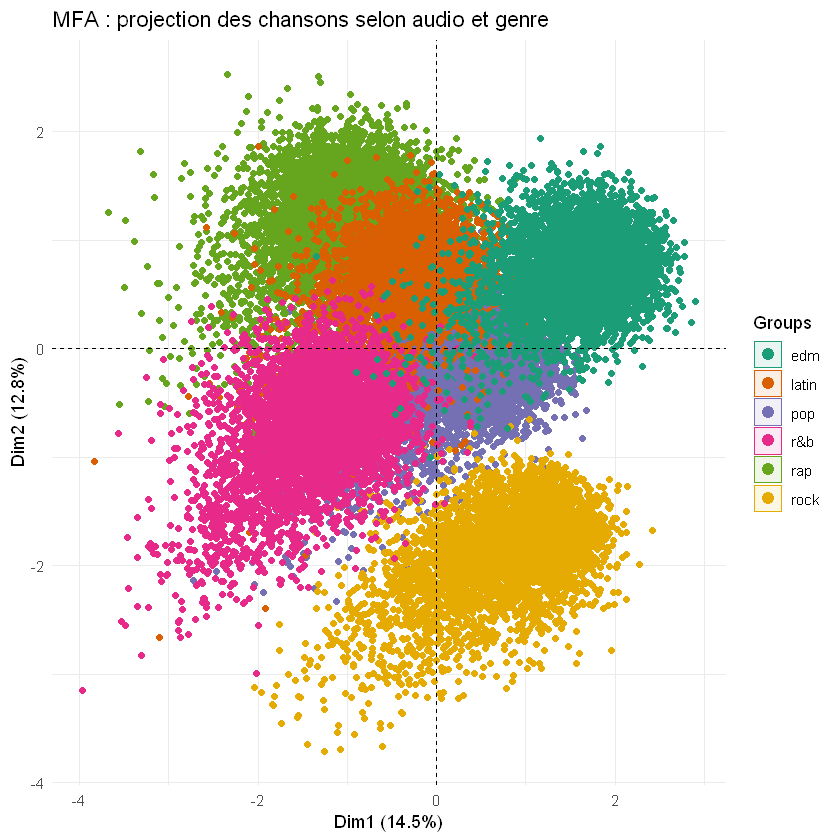

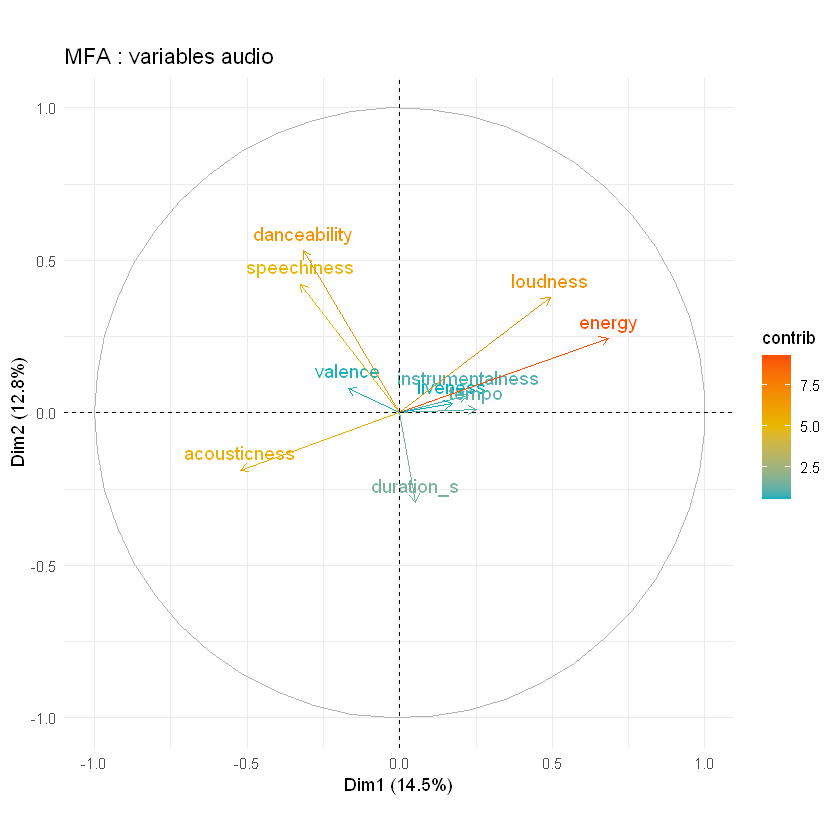

In [26]:
# Analyse Factorielle Multiple (MFA) : audio + genre

# 1. Sélectionner les variables audio (quantitatives) et genre (qualitative)
audio_vars <- c("danceability", "energy", "loudness", "speechiness", "acousticness",
                "instrumentalness", "liveness", "valence", "tempo", "duration_s")
mfa_data <- song[, c(audio_vars, "playlist_genre")]

# S'assurer que playlist_genre est bien un facteur
mfa_data$playlist_genre <- as.factor(mfa_data$playlist_genre)

# 2. Définir les groupes : 10 variables audio (quantitatives), 1 qualitative (genre)
group <- c(length(audio_vars), 1)
type <- c("s", "n")  # 1 groupe quanti, 1 groupe quali

# 3. Réaliser la MFA
mfa <- MFA(mfa_data, group = group, type = type, name.group = c("Audio", "Genre"), graph = FALSE)

# 4. Visualisation des individus colorés par genre
fviz_mfa_ind(mfa, habillage = mfa_data$playlist_genre, palette = "Dark2", addEllipses = TRUE, ellipse.type = "confidence",label="none") +
  labs(title = "MFA : projection des chansons selon audio et genre") +
  theme_minimal()

# 5. Visualisation des variables audio
fviz_mfa_var(mfa, "quanti.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")) +
  labs(title = "MFA : variables audio") +
  theme_minimal()

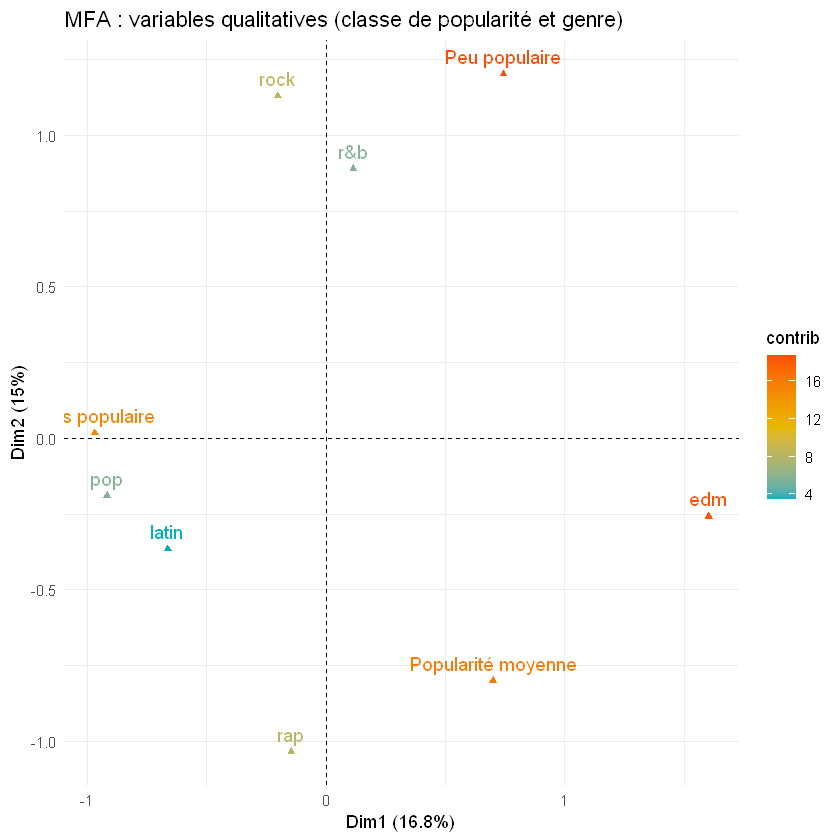

In [29]:
# Création de classe de popularité de track_popularity en facteur Très Populaire, Popularité moyenne, Peu populaire
song$track_popularity_class <- cut(song$track_popularity, 
                                   breaks = c(-1, 20, 50, 100), 
                                   labels = c("Peu populaire", "Popularité moyenne", "Très populaire"),
                                   include.lowest = TRUE)

#MFA avec la classe de popularité et playlist_genre
qual_vars_popularity <- c('track_popularity_class','playlist_genre')
song_mfa_popularity <- song[, qual_vars_popularity]
# S'assurer que track_popularity_class est bien un facteur
song_mfa_popularity$track_popularity_class <- as.factor(song_mfa_popularity$track_popularity_class)
# 2. Définir les groupes : 1 qualitative (classe de popularité), 1 qualitative (genre)
group_popularity <- c(1, 1)
type_popularity <- c("n", "n")  # 2 groupes qualitatifs
# 3. Réaliser la MFA
mfa_popularity <- MFA(song_mfa_popularity, group = group_popularity, type = type_popularity, 
                      name.group = c("Classe de popularité", "Genre"), graph = FALSE)


# 5. Visualisation des variables
fviz_mfa_var(mfa_popularity, "quali.var", col.var = "contrib", 
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")) +
  labs(title = "MFA : variables qualitatives (classe de popularité et genre)") +
  theme_minimal()



## NMF

In [20]:
install.packages("Biobase")
install.packages("NMF")
library(NMF)
# 2. Sélection des colonnes audio uniquement depuis song
audio_features <- song %>%
  select(danceability, energy, loudness, speechiness, acousticness,
         instrumentalness, liveness, valence, tempo, duration_s) %>%
  na.omit()

# 3. Min-max scaling sur chaque colonne
audio_features <- as.data.frame(lapply(audio_features, function(x) (x - min(x)) / (max(x) - min(x))))

# 4. Conversion en matrice
audio_matrix <- as.matrix(audio_features)

# 5. Choix du nombre de composantes (ex. : 4 profils)
nmf_result <- nmf(audio_matrix, rank = 4, method = "brunet", nrun = 10, seed = 123)

# 6. Résumé
print(nmf_result)

# 7. Matrice W (coefficients pour chaque chanson)
W <- basis(nmf_result)

# 8. Matrice H (contributions de chaque feature à chaque profil)
H <- coef(nmf_result)

Warning message:
"le package 'Biobase' n'est pas disponible for this version of R

Une version de ce package pour votre version de R est peut-être disponible ailleurs,
Voyez des idées à
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"
Warning message:
"la dépendance ''Biobase'' n'est pas disponible"



  Une version binaire est disponible mais la version du source est plus
  récente:
    binary source needs_compilation
NMF   0.26   0.28              TRUE

  Binaries will be installed
package 'NMF' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'NMF'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problème lors de la copie de C:\Users\matte\anaconda3\envs\my_r_env\Lib\R\library\00LOCK\NMF\libs\x64\NMF.dll vers C:\Users\matte\anaconda3\envs\my_r_env\Lib\R\library\NMF\libs\x64\NMF.dll: Permission denied"
Warning message:
"restored 'NMF'"



The downloaded binary packages are in
	C:\Users\matte\AppData\Local\Temp\Rtmp08RRCs\downloaded_packages


Le chargement a nécessité le package : Biobase

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
"aucun package nommé 'Biobase' n'est trouvé"


ERROR: Error: le chargement du package ou de l'espace de noms a échoué pour 'NMF' in .requirePackage(package) :
unable to find required package 'Biobase'


In [ ]:
# 1. Sélection des features audio
audio_features <- c('danceability', 'energy', 'loudness', 'speechiness',
                   'acousticness', 'instrumentalness', 'liveness',
                   'valence', 'tempo', 'duration_s')

X <- song[, audio_features]

# 2. Normalisation min-max (important pour la NMF)
X_scaled <- as.data.frame(lapply(X, function(x) (x - min(x)) / (max(x) - min(x))))
X_matrix <- as.matrix(X_scaled)

# 3. Tester plusieurs valeurs de r (nombre de composants)
errors <- c()
r_values <- seq(2, 10, by = 2)

for (r in r_values) {
  nmf_model <- nmf(X_matrix, rank = r, method = "brunet", nrun = 5, seed = 42)
  W <- basis(nmf_model)
  H <- coef(nmf_model)
  reconstruction <- W %*% H
  error <- norm(X_matrix - reconstruction, type = "F") # norme de Frobenius
  errors <- c(errors, error)
}

# 4. Tracer la courbe de l’erreur de reconstruction
plot(r_values, errors, type = "b", pch = 19,
     main = "Erreur de reconstruction vs nombre de composants (r)",
     xlab = "Nombre de composants (r)",
     ylab = "Erreur de reconstruction (norme de Frobenius)")
grid()

#On garde r=6 pour la suite soit 6 profils musicaux

# 5. Application de la NMF avec 6 composantes
nmf_model_6 <- nmf(X_matrix, rank = 6, method = "brunet", nrun = 10, seed = 42)
W_6 <- basis(nmf_model_6)
H_6 <- coef(nmf_model_6)

# 6. Créer un data.frame pour la matrice H
H_df <- as.data.frame(H_6)
colnames(H_df) <- audio_features
rownames(H_df) <- paste0("Profil ", 1:6)

# 7. Affichage de la matrice H
print("Matrice H (profils latents définis par les variables audio) :")

# 8. Visualisation : contribution des variables à chaque profil (heatmap)
library(reshape2)
library(ggplot2)
H_df_long <- melt(as.matrix(H_df))
colnames(H_df_long) <- c("Profil", "Variable", "Valeur")

ggplot(H_df_long, aes(x = Variable, y = Profil, fill = Valeur)) +
    geom_tile() +
    geom_text(aes(label = sprintf("%.2f", Valeur)), size = 3) +
    scale_fill_gradient(low = "#E7F6D5", high = "#2171B5") +
    labs(title = "Profils latents musicaux détectés par NMF (matrice H)",
             x = "Caractéristiques audio", y = "Profils NMF") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Résultats

#### 1. Profils latents détectés

L’analyse a révélé **6 profils musicaux latents** à partir des données. Chaque profil est défini par une combinaison unique de caractéristiques audio. Voici leur interprétation :

* **Profil 1 : Profil Instrumental**

  * Très forte **`instrumentalness`** avec très peu d'autres caractéristiques.
  * Correspond clairement à des morceaux **purement instrumentaux**, probablement **ambient**, **classique** ou **bande-son**.

* **Profil 2 : Profil Énergique-Intense**

  * Caractérisé par de **très fortes valeurs en `energy`, `loudness`, `tempo`, `duration` et `danceability`**.
  * Faible en composantes émotionnelles (`valence`), vocales et instrumentales.
  * Ce profil pourrait correspondre à des morceaux **très dynamiques et bruyants**, typiques de l’**EDM** (house, electro, techno) ou du **hard-rock**/**metal**.

* **Profil 3 : Profil Live**

  * Faibles valeurs générales sauf une **forte `liveness`**.
  * Peut représenter des morceaux **live**.

* **Profil 4 : Profil Émotionnel-Valence**

  * Faible en toutes dimensions sauf une très forte **`valence`**.
  * Ce profil regroupe des morceaux **émotionnellement très positifs**, avec une ambiance **joyeuse ou euphorique**, indépendamment du tempo ou de l’énergie.

* **Profil 5 : Profil Acoustique-Chant**

  * Dominé par une forte **`acousticness`**.
  * Ce profil, présente **`instrumentalness`=0**, et un faible **`speechiness`** mais différent de zéro.
  * Ce profil regroupe possiblement des morceaux **acoustiques et chantés**.

* **Profil 6 : Profil Rap-Rythmé**

  * Forte `danceability` et `speechiness`.
  * Ce profil semble capturer des morceaux **rythmés et très vocaux**, typiques du **rap**, **hip-hop**, voire certains morceaux **R\&B urbains**.

---

Pour chaque profil, nous allons désormais regarder les morceaux qui y contribuent le plus fortement, pour confirmer ces résultats.

In [ ]:
# Pour chaque profil (colonne de W), trouver les 2 morceaux avec la valeur la plus élevée
top_indices_per_profile <- apply(W_6, 2, function(col) order(col, decreasing = TRUE)[1:2])

# Afficher les morceaux correspondants pour chaque profil
for (i in 1:ncol(W_6)) {
    cat(sprintf("\nProfil %d :\n", i))
    indices <- top_indices_per_profile[, i]
    print(song[indices, c("track_name", "track_artist", "playlist_genre", "playlist_subgenre")])
}

### Résultats

#### 1. Profils latents détectés

L’analyse a révélé **6 profils musicaux latents** à partir des données. Chaque profil est défini par une combinaison unique de caractéristiques audio. Voici des exemples de morceaux représentés par les différents profils :

* **Profil 1 : Profil Instrumental**
  * Exemples : `Flowers` de **The Deli**, `Tropical Forest` de **The Sleep Specialist**.

* **Profil 2 : Profil Énergique-Intense**
  * Exemples : `Roar - Adana Twins Remix` de **Patrice Bäumel**, `Tolerance For The Absurd - Acronym Remix` de **Irazu**.

* **Profil 3 : Profil Live**
  * Exemples : `Bienvenidos - Live` de **Miguel Rios**, `Sweet Child O' Mine - Live In Paris / 1992` de **Guns N' Roses**.

* **Profil 4 : Profil Émotionnel-Valence**
  * Exemples : `You Love It!` de **ripmattblack**, `Nobody's Heart` de **Sergeant Jay**.

* **Profil 5 : Profil Acoustique-Chant**
  * Exemples : `Lost Boy` de **Ruth B.**.

* **Profil 6 : Profil Rap-Rythmé**
  * Exemples : `Suge` de **DaBaby**, `LAX` de **B0nds**.

---

Ces résultats confirment les interprétations initiales des profils latents, et montrent que la NMF a réussi à extraire des caractéristiques musicales pertinentes à partir des données audio.

In [ ]:
# Système de recommandation basé sur les profils NMF

# 1. Ajouter les profils NMF comme colonnes au dataframe original
song_with_profiles <- song
song_with_profiles[, paste0("profile_", 1:6)] <- W_6

# 2. Fonction pour recommander des chansons basées sur une playlist
recommend_songs <- function(playlist_name, num_recommendations = 3) {
    # Vérifier si la playlist existe
    if(!(playlist_name %in% song_with_profiles$playlist_name)) {
        stop("Playlist non trouvée dans le dataset")
    }
    
    # Récupérer les morceaux de la playlist
    playlist_songs <- song_with_profiles[song_with_profiles$playlist_name == playlist_name, ]
    
    # Calculer le profil moyen de la playlist
    playlist_profile <- colMeans(playlist_songs[, paste0("profile_", 1:6)])
    
    # Exclure les morceaux déjà dans la playlist
    other_songs <- song_with_profiles[song_with_profiles$playlist_name != playlist_name, ]
    
    # Calculer la similarité (distance euclidienne) entre le profil de la playlist et chaque morceau
    similarities <- apply(other_songs[, paste0("profile_", 1:6)], 1, function(song_profile) {
        -sqrt(sum((song_profile - playlist_profile)^2))  # Négative car nous voulons maximiser
    })
    
    # Trier les morceaux par similarité décroissante
    other_songs$similarity <- similarities
    recommendations <- other_songs[order(other_songs$similarity, decreasing = TRUE), ]
    
    # Retourner les top N recommandations
    return(head(recommendations[, c("track_name", "track_artist", "playlist_genre", "playlist_subgenre", "similarity")], num_recommendations))
}

# 3. Exemple d'utilisation
# Obtenir les noms de playlists uniques
unique_playlists <- unique(song_with_profiles$playlist_name)

# Sélectionner une playlist aléatoire pour démonstration
set.seed(123)
example_playlist <- sample(unique_playlists, 1)

# Afficher le nom de la playlist sélectionnée
cat("Playlist sélectionnée:", as.character(example_playlist), "\n\n")

# Afficher quelques chansons de la playlist sélectionnée
playlist_sample <- song_with_profiles[song_with_profiles$playlist_name == example_playlist, 
                                                                     c("track_name", "track_artist", "playlist_genre")]
cat("Exemple de chansons dans cette playlist:\n")
print(head(playlist_sample, 3))
cat("\n")

# Obtenir les recommandations sous la forme d'un tableau sans les playlist_subgenre
recommendations <- recommend_songs(example_playlist, num_recommendations = 3)
cat("Recommandations de chansons basées sur la playlist sélectionnée:\n")
print(recommendations[, -4])  # Exclure la colonne playlist_subgenre


In [ ]:
# 4. Fonction pour recommander à partir d'une chanson spécifique
recommend_from_song <- function(track_name, track_artist, num_recommendations = 3) {
    # Trouver la chanson dans le dataset
    song_idx <- which(song_with_profiles$track_name == track_name & 
                                        song_with_profiles$track_artist == track_artist)
    
    if(length(song_idx) == 0) {
        stop("Chanson non trouvée dans le dataset")
    }
    
    # Récupérer le profil de la chanson
    song_profile <- as.numeric(song_with_profiles[song_idx[1], paste0("profile_", 1:6)])
    
    # Exclure la chanson elle-même
    other_songs <- song_with_profiles[-song_idx, ]
    
    # Calculer la similarité
    similarities <- apply(other_songs[, paste0("profile_", 1:6)], 1, function(profile) {
        -sqrt(sum((profile - song_profile)^2))
    })
    
    # Trier par similarité
    other_songs$similarity <- similarities
    recommendations <- other_songs[order(other_songs$similarity, decreasing = TRUE), ]
    
    # Retourner les top N recommandations
    return(head(recommendations[, c("track_name", "track_artist", "playlist_genre", "playlist_subgenre", "similarity")], num_recommendations))
}

# Exemple d'utilisation de la recommandation par chanson
# Sélectionner une chanson aléatoire
set.seed(24)
random_song_idx <- sample(1:nrow(song_with_profiles), 1)
example_song <- song_with_profiles[random_song_idx, ]

cat("\n\nRecommandation basée sur une chanson spécifique\n")
cat("\n")

cat("Chanson sélectionnée :\n")
cat("Nom de la chanson:", example_song$track_name, "\n")
cat("Artiste:", as.character(example_song$track_artist), "\n")

# Obtenir les recommandations
song_recommendations <- recommend_from_song(example_song$track_name, example_song$track_artist, 5)
cat("Chansons similaires recommandées:\n")
print(song_recommendations)

In [ ]:
#Recommandation pour la playlist "Tropical Beats"
playlist_name <- "Tropical Beats"
num_recommendations <- 5
recommendations <- recommend_songs(playlist_name, num_recommendations)
cat("Recommandations pour la playlist 'Tropical Beats':\n")
print(recommendations[, -4])  # Exclure la colonne playlist_subgenre

In [ ]:
#Recommandation pour la chanson "Thunderstruck" de "AC/DC"
track_name <- "Thunderstruck"
track_artist <- "AC/DC"
num_recommendations <- 5
recommendations <- recommend_from_song(track_name, track_artist, num_recommendations)
cat("Recommandations pour la chanson 'Thunderstruck' de 'AC/DC':\n")
print(recommendations[, -4])  # Exclure la colonne playlist_subgenre

# Conclusion